# Project: Flame Dynamics Identification

In this project, you will have to develop a neural network that can learn the dynamics of a flame.
More specifically, the flame dynamics represent how the heat release rate of a flame varies when it is subjected to velocity perturbation and has a strong impact on the overall stability of gas turbines or jet engines. Indeed, a coupling mechanism can occur between the velocity flucatuation, heat release fluctuation and the acoustics of the combustor leading to a phenomena called, _thermoacoustic instabilities_.

More specifically, you will need to identify the following relation:
\begin{equation}
\dot{Q}'=\mathcal{F}(u')
\end{equation}

where $\dot{Q}'$ and $u'$ represent the normalized heat release rate oscillation and the normalized velocity perturbation respectively.

To do so, we are providing you with three different sets of time series of $(u'(t),\dot{Q}'(t))$. Each of those time series have been obtained from simulation where the flame was excited with a broadband signal (meaning that there is a large frequency content in the excitation signal).

The tasks for the project are:
1. To train different neural networks for each dataset.
2. To obtain the frequency response of each trained neural network for excitation amplitudes of 0.5, 1.0 and 1.5. Vaildations data are provided for you to assess the accuracy of your trained neural network.

The frequency response is obtained by exciting the neural network with a harmonic signal (meaning a sine at a specified frequency with a fixed amplitude). Then, the gain (ratio between the resulting heat release rate signal and excitation signal: $\dot{Q}'/u'$) and phase (the delay between the two signals) are computed.

3. Study the accuracy of the trained neural network depending on the length of the training signal used.

The remainder of this notebook will provide a guideline solution when using a recurrent neural network (LSTM-based) to the problem above. The exercise and solution are based on the results presented in the following paper [Yadav, V., Casel, M. & Ghani, A., _Physics-informed recurrent neural networks for linear and nonlinear flame dynamics_, Proc. Comb. Inst. (39), 1597-1606 (2023).](https://doi.org/10.1016/j.proci.2022.08.036).

In [1]:
use_colab = True
if use_colab:
    !git clone -b main https://github.com/adoanTUD/CYPHER_MLSchool.git

    # from google.colab import drive
    # drive.mount('/content/drive')

In [2]:
# load the required libraries
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from scipy import signal
import os
import h5py
# pandas is a python library dedicated to data manipulation and analysis
import pandas as pd

import tensorflow as tf

2024-09-10 17:21:04.498446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 17:21:04.875207: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-10 17:21:04.887600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-10 17:21:04.887672: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# 1. Read the input data

989999


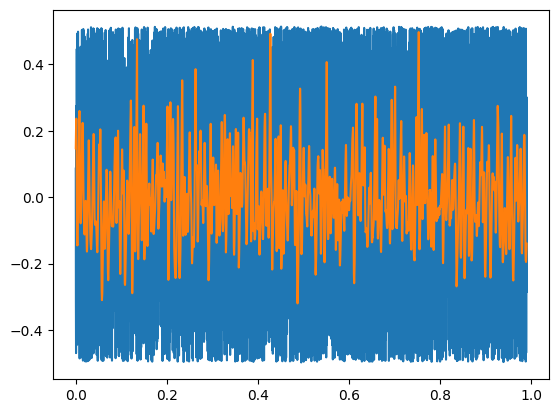

In [3]:
# User defined variables, please provide necessary inputs
# files with *_1.csv: associated with normalized excitation amplitude of 0.5
# files with *_2.csv: associated with normalized excitation amplitude of 1.0
# files with *_3.csv: associated with normalized excitation amplitude of 1.5

if use_colab:
    fld = './CYPHER_MLSchool/'
else:
    fld = '../'
    
input_file = fld + "Flame_Data/input_data_1.csv" # location of input file
output_file = fld + "Flame_Data/output_data_1.csv" # location of output file (true labels)
Ts = 0.000001 # sampling time of the data - all the data have a sampling time of 0.000001 [s]

# load dataset
X_ = pd.read_csv(input_file, header=None)
Y_ = pd.read_csv(output_file, header=None)
T_ = np.arange(X_.shape[0], dtype=int)*Ts
X_ = X_[10000:]
Y_ = Y_[10000:]
T_ = T_[10000:] - T_[10000]
m = X_.shape[0] # number of input data points

%matplotlib inline
plt.figure()
plt.plot(T_,X_)
plt.plot(T_,Y_)

We create hereunder an auxiliary function that will create the input/target pairs for us for a given number of element in the past.

In [ ]:
def create_datasetXY(dataset, labels, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(labels[i + look_back -1, 0])
    return np.array(dataX), np.array(dataY)

Hereunder, we decide on an undersampling rate as we are not interested in the very high frequency response of the flame. In addition, keeping a time-history of ~10 ms is sufficient for this specific flame. Additional details can be found in this paper by [Yadav, V., Casel, M. & Ghani, A., _Physics-informed recurrent neural networks for linear and nonlinear flame dynamics_, Proc. Comb. Inst. (39), 1597-1606 (2023)](https://doi.org/10.1016/j.proci.2022.08.036).

In [4]:
# The data may be oversampled so you may want to downsample it to make the training easier
# we are interested in the frequency content of 0-500Hz
m_sample = 100 # resampling rate

# We are here downsampling the original dataset
resampled_X, resampled_t = signal.resample(X_.values, int(m/m_sample), t=T_) # resample the input
resampled_t = (resampled_t/Ts).astype(int)
resampled_Y = Y_.values[resampled_t,:] # resample the output

# Creating the dataset and deciding on the length of the history to feed to the network
# the sampling rate is 100 mu-s
look_back = 300 # lookback parameter: this results in a history of 30ms
X, Y = create_datasetXY(resampled_X, resampled_Y, look_back)
X = X.reshape((-1,look_back,1))
Y = Y.reshape((-1,1,1))

# split the dataset into training and testing data
split = 0.7
train_samples = int(split*X.shape[0])

X_train = X[0:train_samples,:]
Y_train = Y[0:train_samples,:]

X_test = X[train_samples:m,:]
Y_test = Y[train_samples:m,:]

# 2 Design of the neural network

The network proposed below is based on the paper by [Yadav, V., Casel, M. & Ghani, A., _Physics-informed recurrent neural networks for linear and nonlinear flame dynamics_, Proc. Comb. Inst. (39), 1597-1606 (2023)](https://doi.org/10.1016/j.proci.2022.08.036).

You can play around and try different architectures and assess the results.

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(70, activation='tanh', input_shape=(look_back,1),return_sequences=True))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(35,return_sequences=True, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(1, activation='linear'))

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))

2024-09-10 17:21:11.300486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-09-10 17:21:11.301126: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-09-10 17:21:11.301263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GLaDOS): /proc/driver/nvidia/version does not exist
2024-09-10 17:21:11.303068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
checkpoint_filepath = fld + './checkpoint_RNN.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


EPOCHS = 10 # number of epochs for training the model - Use here a much larger value to ensure that you are fully training your network
BATCH_SIZE = 32
model.fit(X_train, Y_train, batch_size = BATCH_SIZE,
  epochs=EPOCHS, validation_split = 0.1, shuffle = True, verbose=1, callbacks=[early_stop_callback, model_checkpoint_callback])

NameError: name 'fld' is not defined

We assess now the performance of our trained network on the training dataset.

210/210 [==============================] - 34s 154ms/step


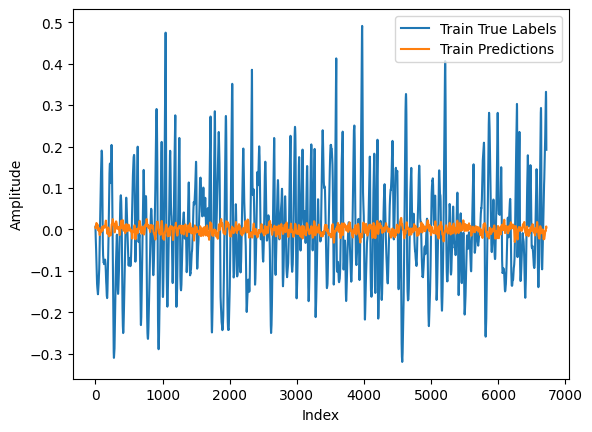

In [7]:
train_predictions = model.predict(X_train)
plt.figure()
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.plot(Y_train.flatten(), label='Train True Labels')
plt.plot(train_predictions.flatten(), label = 'Train Predictions')
plt.legend()

We assess the trained network on the testing dataset (the part of our dataset not used during training).

In [ ]:
test_predictions = model.predict(X_test)

plt.figure()
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.plot(Y_test.flatten(), label='Test True Labels')
plt.plot(test_predictions.flatten(), label = 'Test Predictions')
plt.legend()

# 3. Validation data
As explained, the validation is going to be performed by comparing the frequency response of the neural network and the one from CFD.
The data from the CFD is provided and we show in the code hereunder how to plot it.

In [ ]:
fln = fld + './Validation_data/Flame_valid_data.h5'
hf = h5py.File(fln,'r')
list(hf.keys())
FDF_freq = np.array(hf.get('f'))
FDF_Gain = np.array(hf.get('Gain'))
FDF_phase = np.array(hf.get('phase'))

Each line of those arrays corresponds to excitation amplitude of respectively 0.5, 1.0 and 1.5.

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(3):
    ax.plot(FDF_freq[i,:],FDF_Gain[i,:],'x')
    ax2.plot(FDF_freq[i,:],FDF_phase[i,:],'x')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Gain [-]')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase delay [rad]')

In [ ]:
def generate_sine_wave(amp, freq, fs):
    t = 1
    samples = np.arange(t * fs) / fs
    X_ = amp*np.sin(2 * np.pi * freq * samples)
    X_ = X_.reshape((-1,1))
    return X_

def create_dataset(dataset, look_back):
    dataX = []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return np.array(dataX)



In [ ]:
amp = 0.5 # [-]
# freq = 50 # [Hz]
m = 1000000 # original data is at 1000000 Hz
fs = int(m/m_sample) # resampled frequency is m/m_sample
ts = np.arange(0.1 * fs) / fs # create a 0.1 s long time array with a sample equal to sample rate

Gain_pred = []
phase_pred = []
for ifreq in range(len(FDF_freq[0,:])):
    freq = FDF_freq[0,ifreq]
    Xsin = generate_sine_wave(amp, freq, fs)
    XXsin = create_dataset(Xsin,look_back)
    XXsin = XXsin.reshape((-1,look_back,1))
    YY_sin = model.predict(XXsin)
    YY_sin = YY_sin - np.mean(YY_sin)
    Gain_pred.append(np.max(YY_sin)/np.max(Xsin))
    correlation = signal.correlate(Xsin,YY_sin, mode='full')
    lags = signal.correlation_lags(Xsin.size, YY_sin.size, mode='full')
    lag = lags[np.argmax(correlation)]
    phase_pred.append(lag/fs*np.pi*2.0*freq%(np.pi*2.0))

We compare the flame describing function obtained from our neural network with the one obtained from CFD.

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(1):
    ax.plot(FDF_freq[i,:],Gain_pred)
    ax.plot(FDF_freq[i,:],FDF_Gain[i,:],'x')
    ax2.plot(FDF_freq[i,:],np.unwrap(-np.array(phase_pred))+np.pi)
    ax2.plot(FDF_freq[i,:],FDF_phase[i,:],'x')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Gain [-]')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase delay [rad]')